<h3 style="text-align: center;"><b>Полносвязные и свёрточные нейронные сети</b></h3>

---

Тренировка построению нейронных сетей с помощью библиотеки Pytorch. 

# Import Libraries

---

In [1]:
import os
import platform
import random
import sys
import time
import warnings

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

from tqdm.notebook import tqdm

import cv2

sns.set(style="darkgrid", font_scale=1.4)
warnings.filterwarnings("ignore")

# Library Versions and System Information

---

In [2]:
def time_synchronized() -> float:
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()
    return time.time()


def check_device() -> None:
    input_random = torch.rand(8, 512, 112, 112).to(DEVICE)

    start = time_synchronized()
    _ = nn.Conv2d(512, 1024, 3, groups=1, device=DEVICE)(input_random)
    print(f"Normal convolution take  {time_synchronized() - start:.2f} sec.")

    start = time_synchronized()
    _ = nn.Conv2d(512, 1024, 3, groups=64, device=DEVICE)(input_random)
    print(f"Groupped convolution take  {time_synchronized() - start:.2f} sec.")


def print_lib_info() -> None:
    print(f"Python Platform: {platform.platform()}")
    print(f"Python {sys.version}", end="\n\n")
    print(f"OpenCV {cv2.__version__}")
    print(f"PyTorch Version: {torch.__version__}")
    print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
    print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE", end="\n\n")
    print(f"Target device is {DEVICE.type}")
    check_device()


has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_available() and torch.backends.mps.is_built()
DEVICE = torch.device("mps" if has_mps else ("cuda:0" if has_gpu else "cpu"))

print_lib_info()

Python Platform: macOS-14.1-arm64-arm-64bit
Python 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]

OpenCV 4.8.1
PyTorch Version: 2.2.0.dev20231027
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE

Target device is mps
Normal convolution take  0.26 sec.
Groupped convolution take  0.02 sec.


# Options

---

**CFG** - класс с параметрами нашего эксперимента

In [3]:
class CFG:
    seed = 42
    batch_size = 128
    lr = 0.05


TRAIN = "train"
VALID = "valid"

Зафиксируем seed для воспроизводимости

In [4]:
def seed_everything(seed: int = CFG.seed) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)


seed_everything()

# 1. Dataset moons

---

Сгенерируем датасет и посмотрим на него:

In [5]:
X, y = make_moons(n_samples=10000, random_state=CFG.seed, noise=0.1)

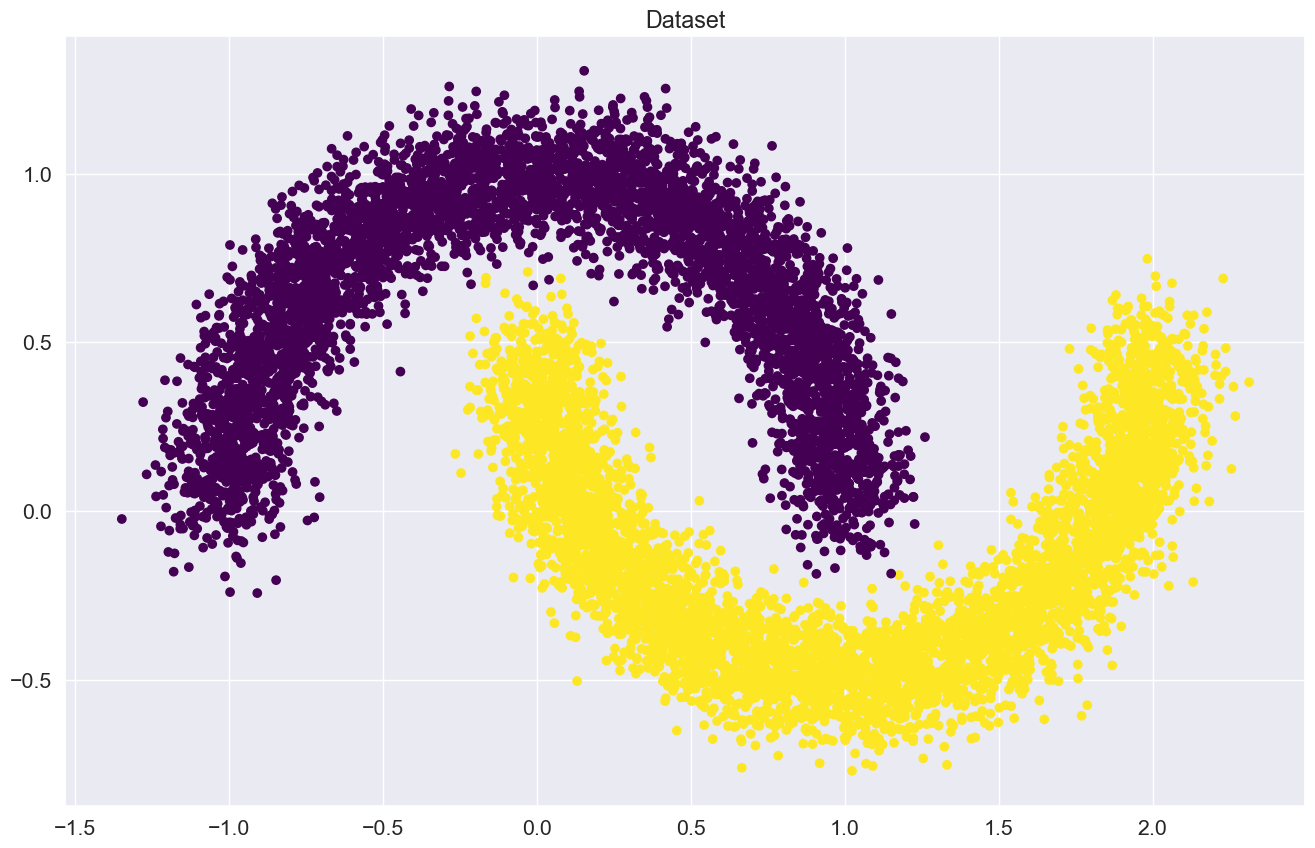

In [6]:
def plot_dataset(X_: np.ndarray, y_: np.ndarray) -> None:
    plt.figure(figsize=(16, 10))
    plt.title("Dataset")
    plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap="viridis")
    plt.show()

plot_dataset(X, y)

Сделаем train/test split

In [7]:
def split_train_test(X_: np.ndarray, y_: np.ndarray, test_size_: float = 0.2) -> tuple:
    return train_test_split(X_, y_, random_state=CFG.seed, test_size=test_size_)


X_train, X_val, y_train, y_val = split_train_test(X, y)

## 1.1. Load data

---

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Create Dataset and DataLoader

---

In [8]:
def convert_np_to_tensor(array_: np.ndarray) -> Tensor:
    return torch.from_numpy(array_).type(torch.float32)


X_train_t = convert_np_to_tensor(X_train)
y_train_t = convert_np_to_tensor(y_train)
X_val_t = convert_np_to_tensor(X_val)
y_val_t = convert_np_to_tensor(y_val)

X_train_t.dtype, y_train_t.dtype, X_val_t.dtype, y_val_t.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

Создаем `Dataset` и `DataLoader`.

In [9]:
def create_dataloader(X_: Tensor, y_: Tensor, shuffle_: bool = False, num_workers_: int = 0) -> DataLoader:
    return DataLoader(
        TensorDataset(X_, y_), 
        batch_size=CFG.batch_size, 
        shuffle=shuffle_, 
        num_workers=num_workers_
    )


train_dataloader = create_dataloader(X_train_t, y_train_t, shuffle_=True)
val_dataloader = create_dataloader(X_val_t, y_val_t)

## 1.2. Logistic regression is my profession

---

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии:
- На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта.
- Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$.
- Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоида. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Realization of logistic regression

---

Напишем модуль на PyTorch, реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. 
Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). 
Инициализируйте веса нормальным распределением (`torch.randn`).

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        seed_everything()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True) if bias else None

    def forward(self, x_: Tensor) -> Tensor:
        x_ = x_ @ self.weights
        if self.bias_term is not None:
            x_ += self.bias_term
        return x_.reshape(-1)

In [11]:
linear_regression = LinearRegression(2, 1).to(DEVICE)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=CFG.lr)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [12]:
def count_parameters(model_: nn.Module) -> None:
    print(f"Кол-во обучаемых параметров: {sum(p.numel() for p in model_.parameters() if p.requires_grad)}")


count_parameters(linear_regression)

Кол-во обучаемых параметров: 3


**Ответ:** 3

## 1.3. Train loop

---

Вот псевдокод, который поможет нам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Realization of train loop

---

In [13]:
seed_everything()

tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in tqdm(range(max_epochs)):
    for it, (X_batch, y_batch) in enumerate(tqdm(train_dataloader)):
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        
        optimizer.zero_grad()

        linear_regression.train()
        output = linear_regression(X_batch)
        
        loss = loss_function(output, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0].data.cpu().numpy())
        optimizer.step()
        
        probabilities = 1 / (1 + torch.exp(-output))
        pred_class = (probabilities > 0.5).type(torch.long)
        batch_accuracy = (pred_class.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_accuracy}")
        
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.", end="\n\n")
            stop_it = True
            break
        
        prev_weights = current_weights
    
    if stop_it:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 0
Batch accuracy: 0.5703125


  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 100
Batch accuracy: 0.8203125


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 200
Batch accuracy: 0.8125


  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 300
Batch accuracy: 0.8203125


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 400
Batch accuracy: 0.8359375


  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 500
Batch accuracy: 0.8515625


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 600
Batch accuracy: 0.8359375


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Iteration: 700
Batch accuracy: 0.875


  0%|          | 0/63 [00:00<?, ?it/s]


Iteration: 778.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 778

## 1.4. Visualize results

---

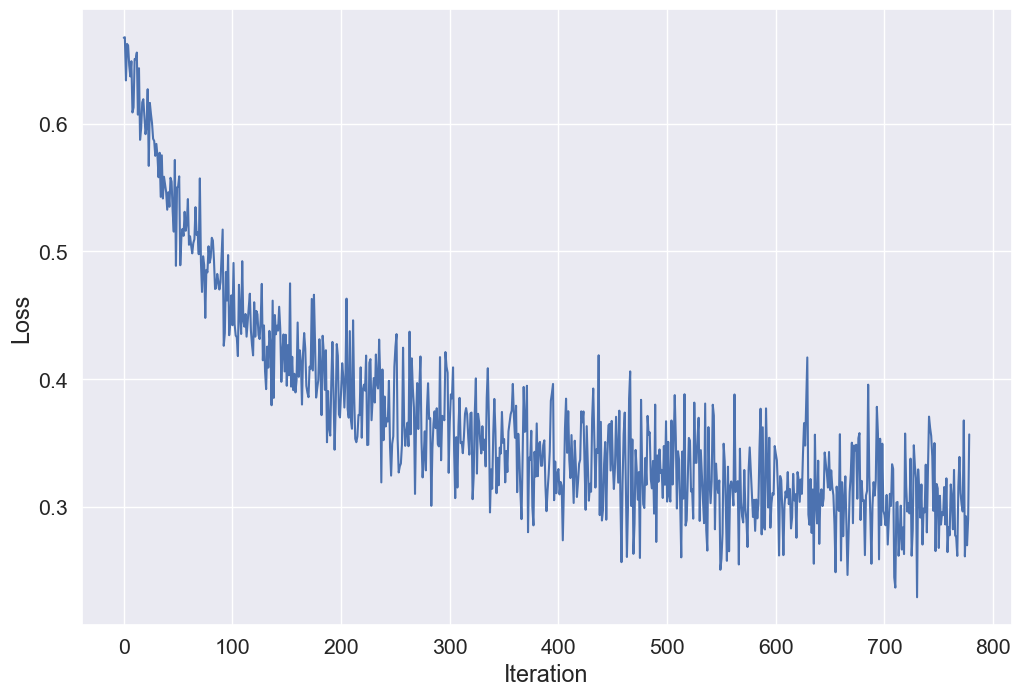

In [14]:
def plot_loss(losses_: list) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(losses_)), losses_)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    
    plt.show()


plot_loss(losses)

In [15]:
sns.set(style="white")

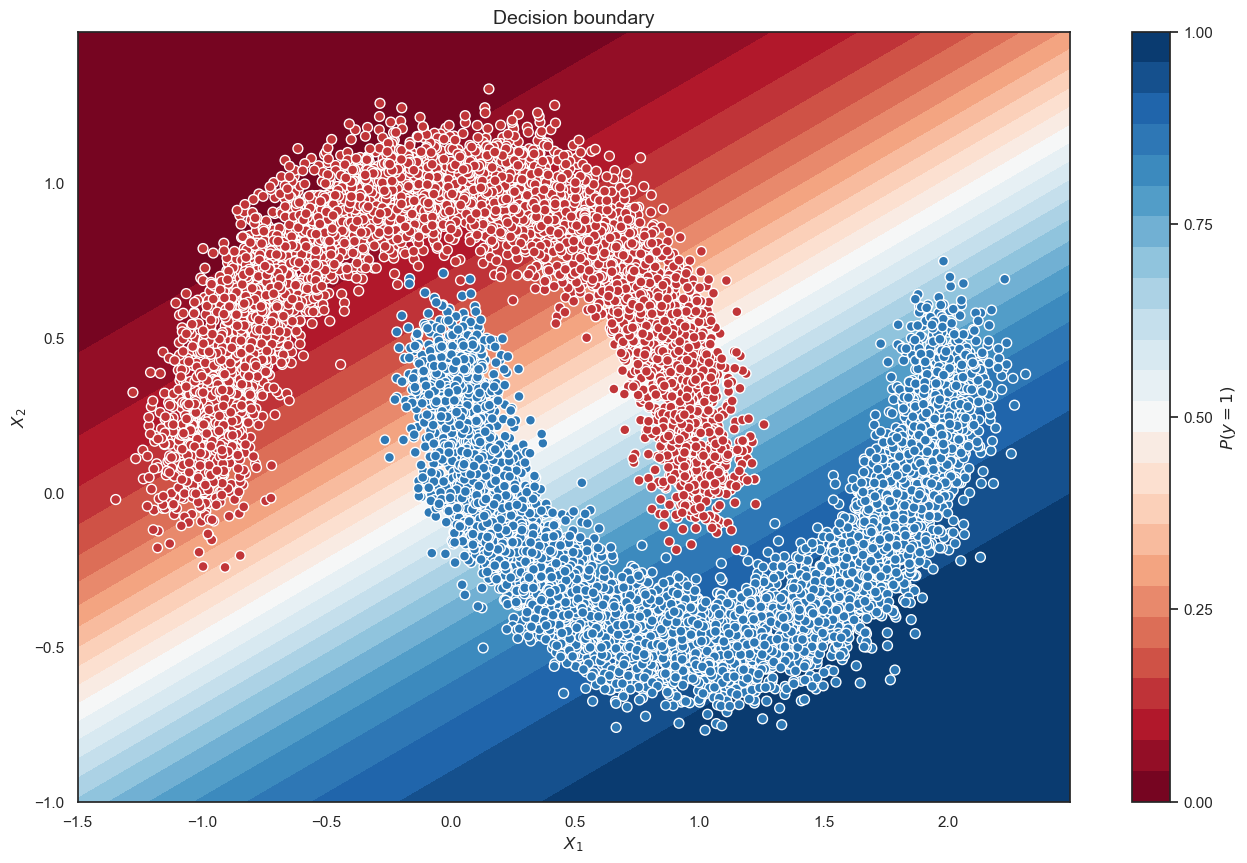

In [16]:
xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]

grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch.to(DEVICE)).reshape(xx.shape))
    probs = probs.data.cpu().numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))

contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(
    X[100:,0], 
    X[100:, 1], 
    c=y[100:], 
    s=50,
    cmap="RdBu", 
    vmin=-.2, 
    vmax=1.2,
    edgecolor="white", 
    linewidth=1
)

ax.set_title("Decision boundary", fontsize=14)
ax.set(xlabel="$X_1$", ylabel="$X_2$")

plt.show()

### Realization of predict and calculate accuracy

---

In [17]:
@torch.no_grad()
def predict(dataloader_: DataLoader, model_: nn.Module) -> np.ndarray:
    model_.eval()
    predictions = np.array([])
    for x_batch_, _ in tqdm(dataloader_):
        x_batch_ = x_batch_.to(DEVICE)
        pred_class_ = model_(x_batch_)
        pred_class_ = (1 / (1 + torch.exp(-pred_class_)) > 0.5).type(torch.long)
        predictions = np.hstack((predictions, pred_class_.cpu().numpy().flatten()))
    return predictions.flatten()

In [18]:
accuracy_score(y_val, predict(val_dataloader, linear_regression))

  0%|          | 0/16 [00:00<?, ?it/s]

0.8735

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8735

# 2. Dataset MNIST

---

Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы:

In [19]:
def load_mnist(data_tfs_: tfs.Compose, phase_: str) -> MNIST:
    return MNIST(root="./", transform=data_tfs_, train=(phase_ == TRAIN), download=True)


def load_mnist_data() -> tuple:
    data_tfs = tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.1307,), (0.3081,))])
    return load_mnist(data_tfs, TRAIN), load_mnist(data_tfs, VALID)


def create_dataloader_mnist(train_dataset_: MNIST, val_dataset_: MNIST) -> tuple:
    train_dataloader_ = DataLoader(train_dataset_, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader_ = DataLoader(val_dataset_, batch_size=CFG.batch_size, shuffle=False)
    return train_dataloader_, val_dataloader_
    

train_dataset, val_dataset = load_mnist_data()
train_dataloader, val_dataloader = create_dataloader_mnist(train_dataset, val_dataset)

## 2.1. Fully connected neural networks

---

Сначала решим MNIST с помощью полносвязной нейронной сети.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Simple fully connected neural network

---

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Зададим лосс для обучения (кросс-энтропия).


In [21]:
img_size = 28 * 28
hidden_size = 128
output_size = len(train_dataset.classes)

In [22]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(img_size, hidden_size),
    activation(),
    nn.Linear(hidden_size, hidden_size),
    activation(),
    nn.Linear(hidden_size, output_size)
).to(DEVICE)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {TRAIN: train_dataloader, VALID: val_dataloader}

### Train loop

---

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

#### Realization of train loop

---

In [24]:
def train_val_model(model_, loss_, optimizer_, num_epochs_: int) -> tuple:
    seed_everything()
    
    hist_dct = {"loss": {TRAIN: [], VALID: []}, "acc": {TRAIN: [], VALID: []}}
    best_accuracy = 0.
    
    for epoch_ in range(num_epochs_):
        print("=" * 20)
        print(f"Epoch {epoch_ + 1}/{num_epochs_}:")
        
        for phase, dataloader_ in loaders.items():
            model_.train(mode=(phase == TRAIN)) if phase == TRAIN else model_.eval()
            running_loss, running_accuracy = 0., 0.

            for inputs, labels in tqdm(dataloader_):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                optimizer_.zero_grad()  # Обнуляем градиент, чтобы он не накапливался
                with torch.set_grad_enabled(phase == TRAIN):  # Если фаза train, активируем все градиенты (не замороженные)
                    output_ = model_(inputs)  # Считаем предикты, input передаем в модель
                    loss_value = loss_(output_, labels)  # Посчитали  Loss
                    pred_class_ = output_.argmax(dim=-1)  # Получаем класс, берем нейрон с максимальной активацией
                    
                    if phase == TRAIN:
                        loss_value.backward()  # Считаем градиент и шаг градиентного спуска
                        optimizer_.step()
                
                running_loss += loss_value.item()
                running_accuracy += (pred_class_ == labels.data).float().mean().data.cpu().numpy()

            hist_dct["loss"][phase].append(running_loss / len(dataloader_))  # Loss'ы делим на кол-во бачей в эпохе
            hist_dct["acc"][phase].append(running_accuracy / len(dataloader_))  # Считаем Loss на кол-во бачей в эпохе
            print(f"{phase} loss: {hist_dct['loss'][phase][-1]:.2f} accuracy: {hist_dct['acc'][phase][-1]:.2f}")

            if (phase == VALID) and (hist_dct["acc"][phase][-1] > best_accuracy):
                best_accuracy = hist_dct["acc"][phase][-1]
        
        print("=" * 20)
    return model_, hist_dct["loss"], hist_dct["acc"]


max_epochs = 10
model, loss, accuracy = train_val_model(model, criterion, optimizer, max_epochs)

Epoch 1/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.29 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.15 accuracy: 0.95
Epoch 2/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.12 accuracy: 0.96


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.10 accuracy: 0.97
Epoch 3/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.08 accuracy: 0.97


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.97
Epoch 4/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.06 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 5/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.05 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98
Epoch 6/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.04 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98
Epoch 7/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98
Epoch 8/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98
Epoch 9/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.97
Epoch 10/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98


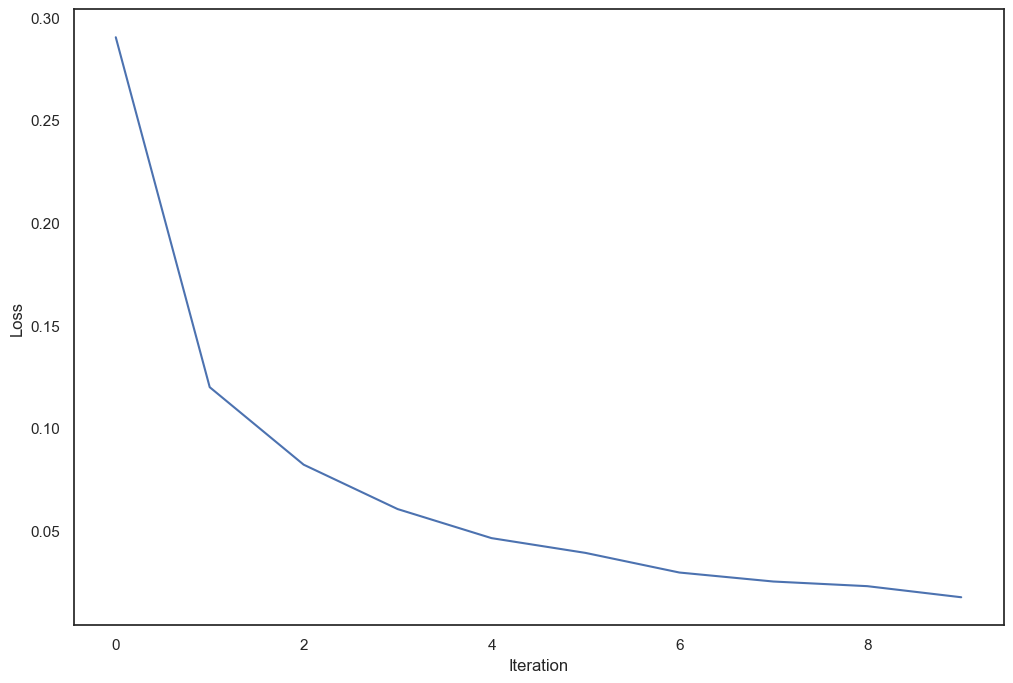

In [25]:
plot_loss(loss[TRAIN])

### Test different activation functions

---

Попробуем разные функции активации. Для каждой функции активации посчитаем массив validation accuracy. Реализуем это в виде функции, получающей на вход активацию и возвращающей массив из accuracies.

In [26]:
elu_accuracy = accuracy[VALID]

In [27]:
def test_activation_function(activation_) -> list:
    seed_everything()
    
    model_ = nn.Sequential(
        nn.Flatten(),
        nn.Linear(img_size, hidden_size),
        activation_(),
        nn.Linear(hidden_size, hidden_size),
        activation_(),
        nn.Linear(hidden_size, output_size)
    ).to(DEVICE)
    
    criterion_ = nn.CrossEntropyLoss()
    optimizer_ = torch.optim.Adam(model_.parameters())
    
    _, _, accuracy_ = train_val_model(model_, criterion_, optimizer_, max_epochs)
    return accuracy_[VALID]

In [28]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch 1/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.38 accuracy: 0.89


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.31 accuracy: 0.91
Epoch 2/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.31 accuracy: 0.91


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.30 accuracy: 0.91
Epoch 3/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.30 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.29 accuracy: 0.92
Epoch 4/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.29 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.29 accuracy: 0.92
Epoch 5/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.29 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.28 accuracy: 0.92
Epoch 6/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.29 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.30 accuracy: 0.91
Epoch 7/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.28 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.29 accuracy: 0.92
Epoch 8/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.28 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.31 accuracy: 0.91
Epoch 9/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.28 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.28 accuracy: 0.92
Epoch 10/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.28 accuracy: 0.92


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.29 accuracy: 0.92
Epoch 1/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.30 accuracy: 0.91


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.15 accuracy: 0.95
Epoch 2/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.12 accuracy: 0.96


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.10 accuracy: 0.97
Epoch 3/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.09 accuracy: 0.97


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.09 accuracy: 0.97
Epoch 4/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.06 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.09 accuracy: 0.97
Epoch 5/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.05 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 6/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.04 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 7/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 8/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 9/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.09 accuracy: 0.98
Epoch 10/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 1/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.30 accuracy: 0.91


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.15 accuracy: 0.95
Epoch 2/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.12 accuracy: 0.96


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.10 accuracy: 0.97
Epoch 3/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.08 accuracy: 0.97


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.09 accuracy: 0.97
Epoch 4/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.06 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.09 accuracy: 0.97
Epoch 5/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.05 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98
Epoch 6/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.04 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 7/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 8/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98
Epoch 9/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.09 accuracy: 0.98
Epoch 10/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.08 accuracy: 0.98


### Accuracy

---

Построим график accuracy/epoch для каждой функции активации.

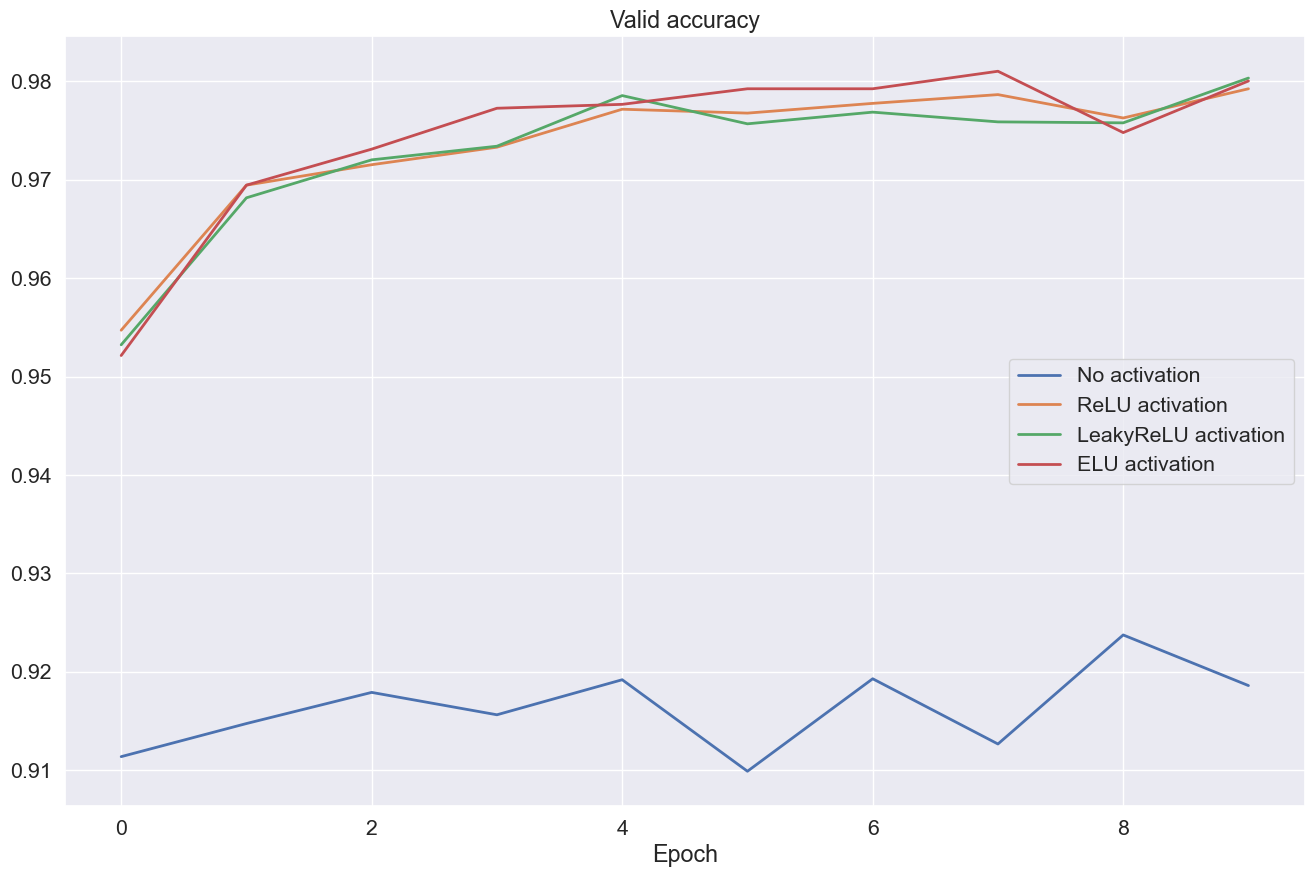

In [29]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))

plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)

plt.legend()
plt.title("Valid accuracy")
plt.xlabel("Epoch")

plt.show()

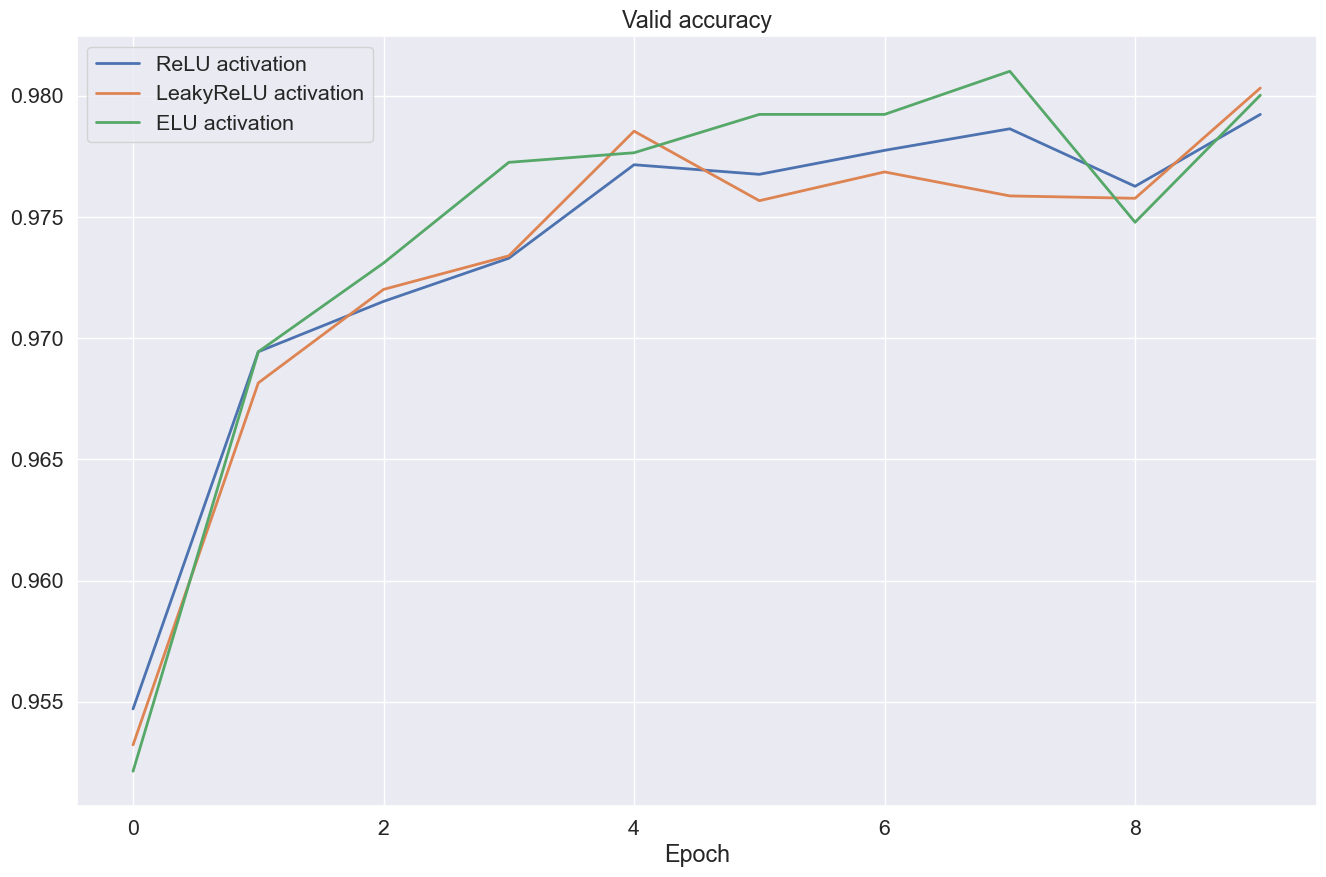

In [30]:
plt.figure(figsize=(16, 10))

plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)

plt.legend()
plt.title("Valid accuracy")
plt.xlabel("Epoch")

plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU показала наивысший accuracy _(однако, если под "концом обучения" подразумевать 10-ая эпоха, то LeakyReLU показала наивысший результат в данной эпохе)_

## 2.2. Convolutional neural networks

---

### Kernel

---

Сначала немного поработам с самим понятием ядра свёртки.

In [31]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-30 21:42:54--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.09s   

2023-10-30 21:42:54 (509 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



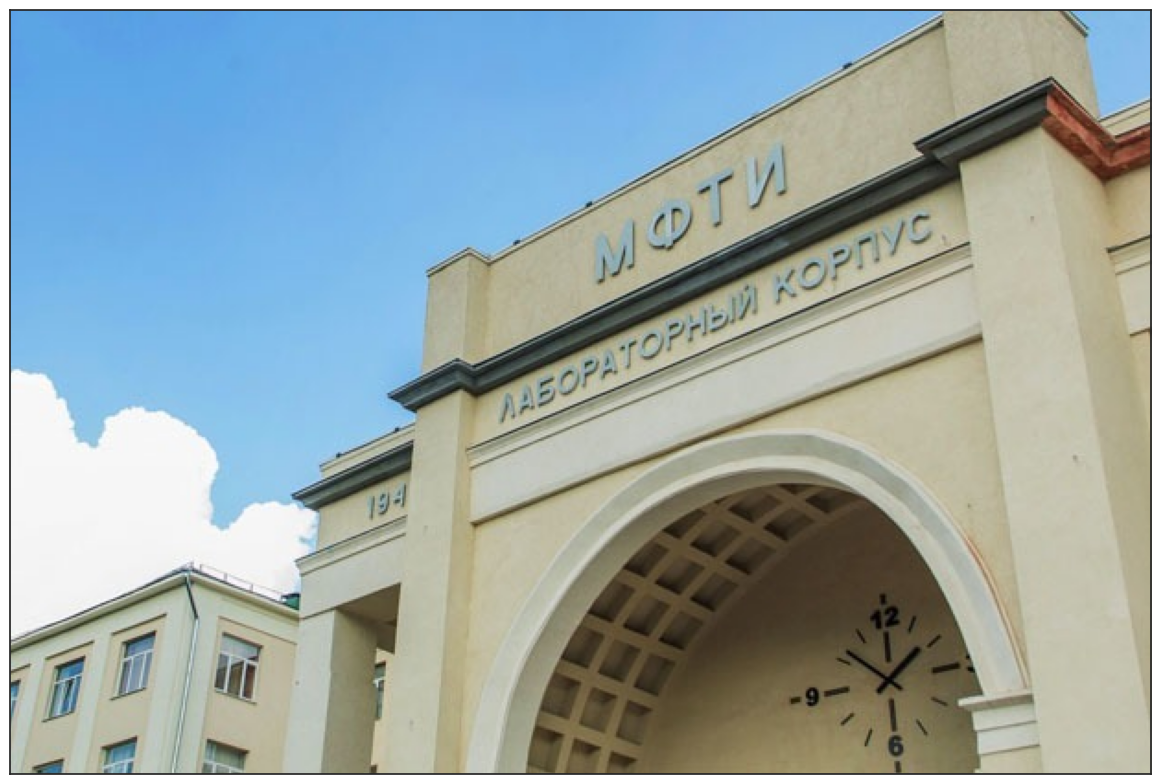

In [32]:
sns.set(style="white")

plt.figure(figsize=(12, 8))

RGB_img = cv2.cvtColor(cv2.imread("sample_photo.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

plt.yticks([])
plt.xticks([])
plt.tight_layout()

plt.show()

Попробуем посмотреть как различные свертки влияют на фото. Например, попробуем применить следующие ядра:
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

И добавим два своих варианта:

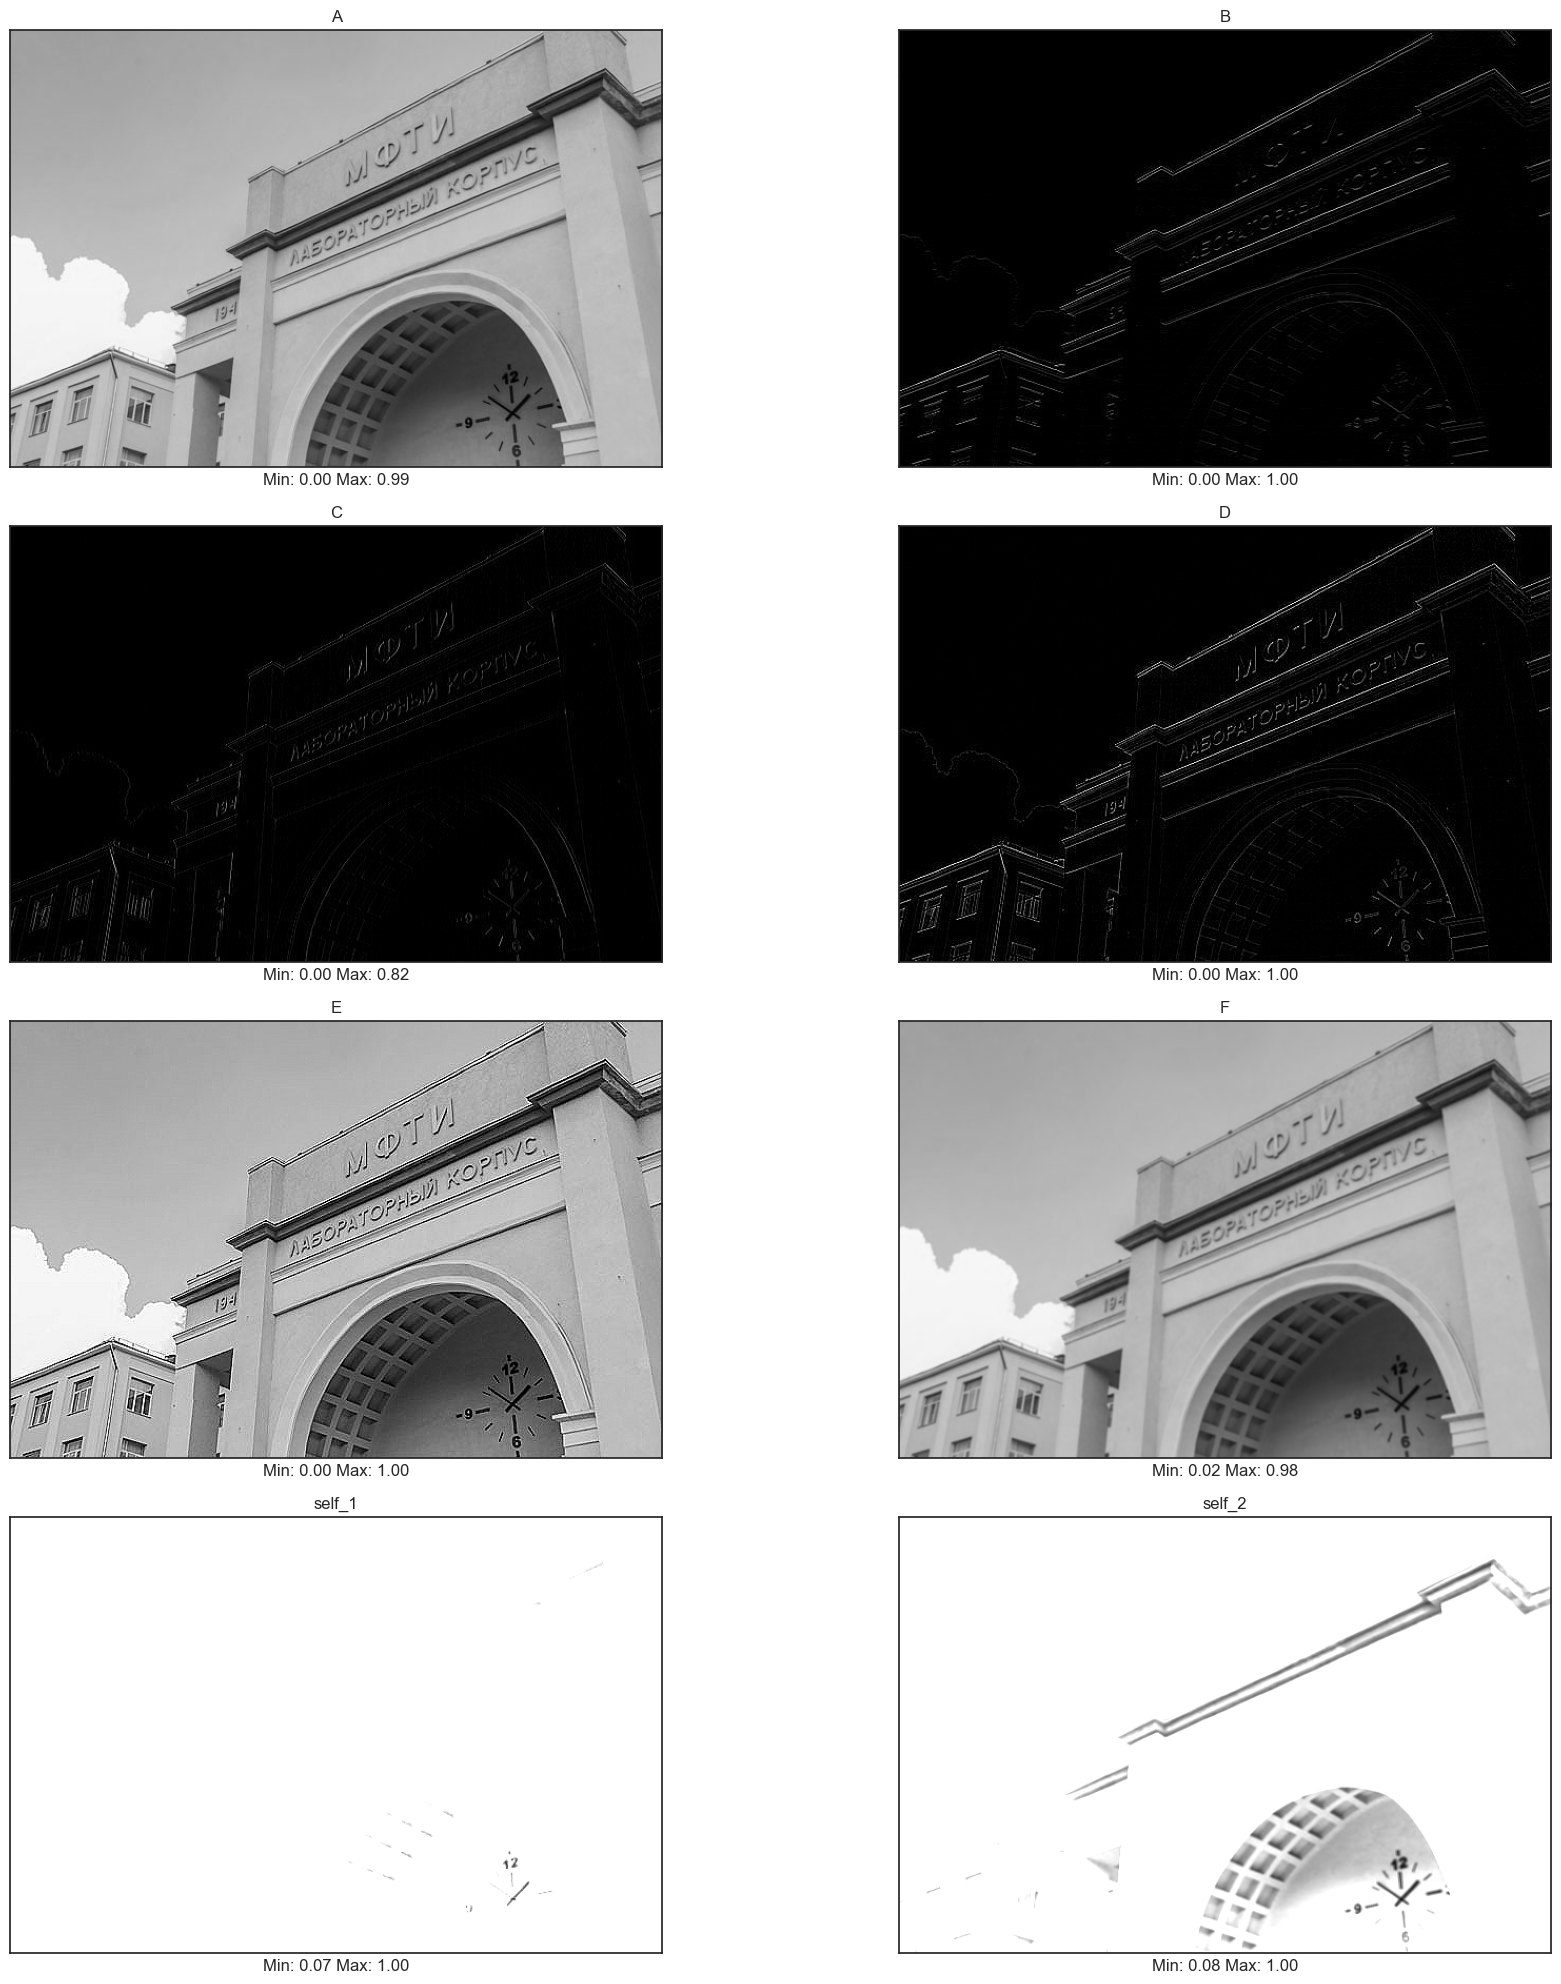

In [33]:
kernels_dct = dict(
    A=np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]),
    B=np.array([
        [0, 1, 0],
        [0, -2, 0],
        [0, 1, 0]
    ]),
    C=np.array([
        [0, 0, 0],
        [1, -2, 1],
        [0, 0, 0]
    ]),
    D=np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ]),
    E=np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ]),
    F=np.array([
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]
    ]),
    self_1=np.array([
        [np.random.randint(-4, 5) for _ in range(3)],
        [np.random.randint(-4, 5) for _ in range(3)],
        [np.random.randint(-4, 5) for _ in range(3)]
    ]),
    self_2=np.array([
        [0.552, 0.018, 0.552],
        [0.318, 0.492, 0.318],
        [0.552, 0.018, 0.552]
    ])
)

fig, axes = plt.subplots(4, 2, figsize=(20, 20))

img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

for i, (k, v) in enumerate(kernels_dct.items()):
    kernel = torch.tensor(v).reshape(1, 1, 3, 3).type(torch.float32).repeat(3, 3, 1, 1)
    
    result = F.conv2d(img_t, kernel)[0]
    result_np = np.clip(result.permute(1, 2, 0).numpy() / 256 / 3, 0, 1)
    
    axes[i // 2, i % 2].imshow(result_np, cmap="gray")
    axes[i // 2, i % 2].set_title(k)
    axes[i // 2, i % 2].set_xticks([])
    axes[i // 2, i % 2].set_yticks([])
    axes[i // 2, i % 2].set_xlabel(f"Min: {result_np.min():.2f} Max: {result_np.max():.2f}")

plt.tight_layout()

plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

---

**Ответ:**

1 - **F**

2 - **E**

3 - **A**

4 - **C**

5 - **B**

6 - **D**

### LeNet

---

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуем архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используем модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [34]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.input_layer = 1
        
        self.conv_layer_1 = 6
        self.conv_layer_2 = 16
        
        self.kernel_size = 3
        self.pool_size = 2
        
        self.lin_layer_1 = 120
        self.lin_layer_2 = 84
        
        self.output_layer = 10
        
        self.conv1 = nn.Conv2d(self.input_layer, self.conv_layer_1, self.kernel_size)
        self.conv2 = nn.Conv2d(self.conv_layer_1, self.conv_layer_2, self.kernel_size)
        
        self.fc1 = nn.Linear(self.conv_layer_2 * 5 * 5, self.lin_layer_1)
        self.fc2 = nn.Linear(self.lin_layer_1, self.lin_layer_2)
        self.fc3 = nn.Linear(self.lin_layer_2, self.output_layer)

    def forward(self, x_: Tensor) -> Tensor:
        x_ = F.max_pool2d(F.relu(self.conv1(x_)), self.pool_size)
        x_ = F.max_pool2d(F.relu(self.conv2(x_)), self.pool_size)
        x_ = torch.flatten(x_, 1)
        x_ = F.relu(self.fc1(x_))
        x_ = F.relu(self.fc2(x_))
        x_ = self.fc3(x_)
        return x_

In [35]:
model = LeNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {TRAIN: train_dataloader, VALID: val_dataloader}

### Train CNN

---

Используем код обучения, который мы написали для полносвязной нейронной сети:

In [36]:
max_epochs = 10
model, loss, accuracy = train_val_model(model, criterion, optimizer, max_epochs)

Epoch 1/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.38 accuracy: 0.89


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.10 accuracy: 0.97
Epoch 2/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.09 accuracy: 0.97


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.07 accuracy: 0.98
Epoch 3/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.06 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.05 accuracy: 0.98
Epoch 4/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.05 accuracy: 0.98


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.05 accuracy: 0.98
Epoch 5/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.04 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.04 accuracy: 0.99
Epoch 6/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.04 accuracy: 0.99
Epoch 7/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.04 accuracy: 0.99
Epoch 8/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.03 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.03 accuracy: 0.99
Epoch 9/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.04 accuracy: 0.99
Epoch 10/10:


  0%|          | 0/469 [00:00<?, ?it/s]

train loss: 0.02 accuracy: 0.99


  0%|          | 0/79 [00:00<?, ?it/s]

valid loss: 0.03 accuracy: 0.99


In [37]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

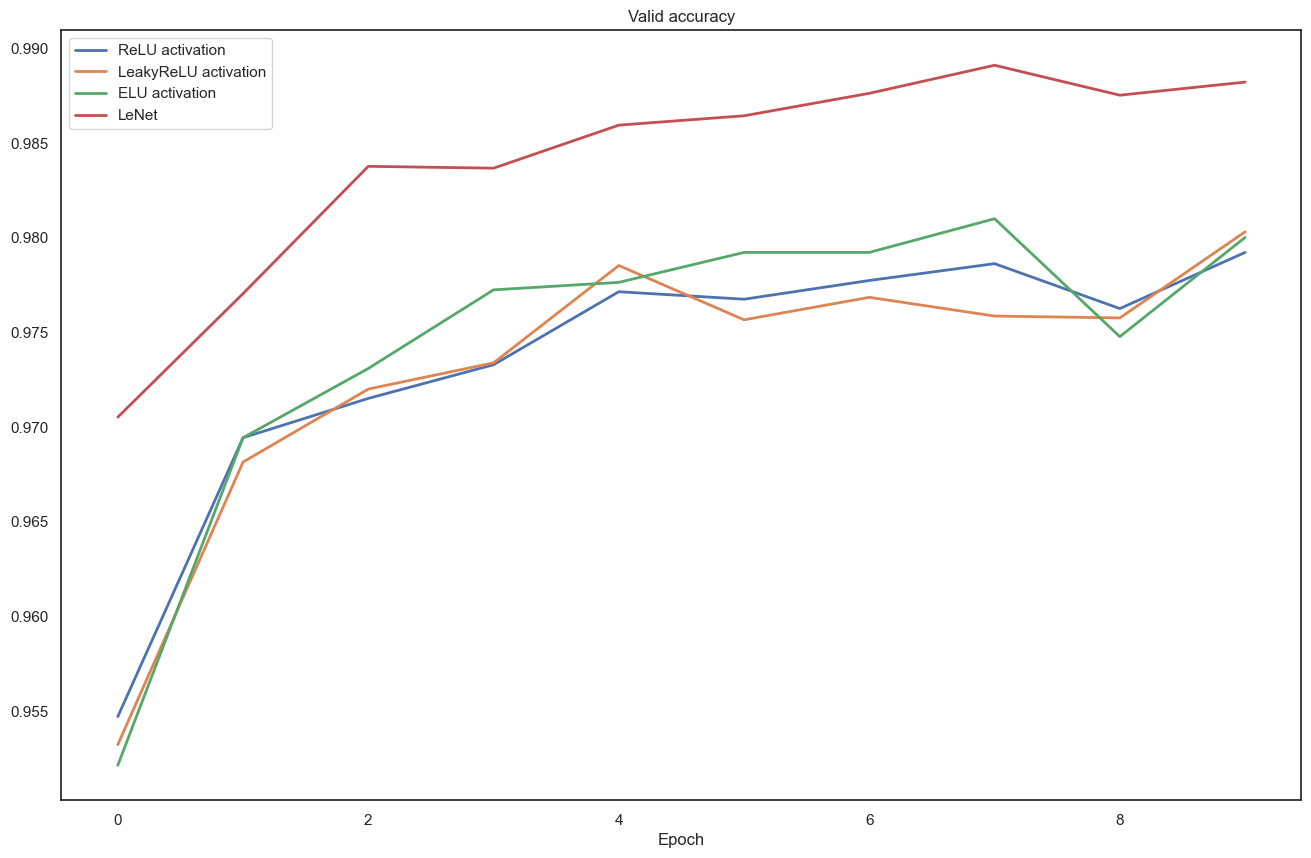

In [38]:
plt.figure(figsize=(16, 10))

plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)

plt.title("Valid accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99